In [ ]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import ast    # converte str de list to list
import re
import string
import nltk
import tensorflow as tf
import codecs
 
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
 
 
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [ ]:
from nltk.corpus import stopwords    
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
stemmer= PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# un dictionnaire que va contenir on clé le nom du model et on valeur ( le model , f1_score)
model_score={}

#Préparation des données 

On a 3 bases de données movie_characters_metadata , movie_lines et movie_conversations.

##Charger toutes les données

In [ ]:
# a partir de la base movie_characters_metadata on va cree deux base de données :
  # data_ch_ente qu'est la base de l'entrianement 
  # data_ch_pred qu'est la base de prediction qui a gendre manquant et qu'on va l'estimer 
data_ch_ente=[]
data_ch_pred=[]
f = open("/content/gdrive/My Drive/data set projet ML/movie_characters_metadata.txt", "r",encoding="ISO-8859-1")
for x in f:
  l=x.split(' +++$+++ ')
  l[len(l)-1]=l[len(l)-1].replace("\n","")
  if(l[len(l)-2]=="?"):
    data_ch_pred.append(l)
  else:
    l[len(l)-2]=l[len(l)-2].upper()
    data_ch_ente.append(l)
        
col_ch=["characterID","character_name","movieID","movie_title","gender","position"]
df_ch_ente=pd.DataFrame(data_ch_ente,columns=col_ch)    
df_ch_pred=pd.DataFrame(data_ch_pred,columns=col_ch) 

# on va transformer les sexe telleque M =1  et F=0 
df_ch_ente['gender'][df_ch_ente["gender"] == "M"] = 1 
df_ch_ente['gender'][df_ch_ente["gender"] == "F"] = 0

In [ ]:
def manip(s):
    resu=[]
    s=s.lower()
    s = re.sub(r"what's", "what is ", s)
    s = re.sub(r"\'s", " ", s)
    s = re.sub(r"\'ve", " have ", s)
    s = re.sub(r"can't", "can not ", s)
    s = re.sub(r"n't", " not ", s)
    s = re.sub(r"i'm", "i am ", s)
    s = re.sub(r"\'re", " are ", s)
    s = re.sub(r"\'d", " would ", s)
    s = re.sub(r"\'ll", " will ", s)
    s = re.sub(r"\'scuse", " excuse ", s)
    s = re.sub('\W', ' ', s)
    s = re.sub('\s+', ' ', s)
    s = re.sub(r'\d+', '', s)
    s = s.translate(str.maketrans('','',string.punctuation))
    s=s.strip()
    tokens = word_tokenize(s)
    list_s = [i for i in tokens if not i in stop_words]
    for word in list_s:
        resu.append(stemmer.stem(word))
    
    w=' '.join(resu)
    return(w)

In [ ]:
data_li=[]
f = open("/content/gdrive/My Drive/data set projet ML/movie_lines.txt", "r",encoding="ISO-8859-1")
for x in f:
    l=x.split(' +++$+++ ')
    l[len(l)-1]=l[len(l)-1].replace("\n","")
    l[len(l)-1]=manip(l[len(l)-1])
    data_li.append(l)
    
col_li=["lineID","characterID","movieID","character_name","text__utterance"]
df_li=pd.DataFrame(data_li,columns=col_li)
del data_li

In [ ]:
d={df_li.loc[i]['lineID']:df_li.loc[i]['text__utterance'] for i in range(len(df_li))}

In [ ]:
data_con=[]
f = open("/content/gdrive/My Drive/data set projet ML/movie_conversations.txt", "r")
for x in f:
    l=x.split(' +++$+++ ')
    l[len(l)-1]=l[len(l)-1].replace("\n","")
    l[len(l)-1]=ast.literal_eval(l[len(l)-1])
    l[len(l)-1]=[d[i] for i in l[len(l)-1]]
    data_con.append(l)
    
col_con=["characterID_first","characterID_second","movieID","utterances"]
df_con=pd.DataFrame(data_con,columns=col_con)
del d
del data_con

##Jointure

Apres avoire lire les 3 bases de données , on va faire la jointure entre les eux de cette façon:
on se basant sur de la colonne characterID de movie_characters_metadata et la colonne characterID_first de movie_conversations on va faire on faire la jointure vue que on a deja fusionner movie_line et movie_conversations.  

In [ ]:
def data_to_dict(df_ch,df_con):
  d_id={}
  for i in range(len(df_ch)):
    x=df_ch.loc[i]
    if(x["characterID"] in d_id):
      d_id[x["characterID"]].append(x["gender"])
    else:
      d_id[x["characterID"]]=[x["gender"]]
  d_con={}
  for j in list(df_con.index):
    x=df_con.loc[j]
    if(x["characterID_first"] in d_con):
      d_con[x["characterID_first"]]=d_con[x["characterID_first"]]+x["utterances"]
    else:
      d_con[x["characterID_first"]]=x["utterances"]
  return((d_id , d_con))

In [ ]:
def Merge(d_id,d_con):
  merge=[]
  for i in d_id:
    if(i in d_con):
      merge.append( [i,d_con[i],d_id[i][0]] )

  col=["id","text__utterance","gender"]
  df_f=pd.DataFrame(merge,columns=col)
  return(df_f)

In [ ]:
d_id_ente,d_con=data_to_dict(df_ch_ente,df_con)

In [ ]:
df_f=Merge(d_id_ente,d_con)

In [ ]:
df_f.head(5)

,id,text__utterance,gender
0,u0,[make quick roxann korrin andrew barrett incre...,0
1,u2,"[new guy, tell, cmon im suppos give tour, dako...",1
2,u4,"[vintag look kat havent read sassi, yeah notic...",1
3,u5,"[who, patrick verona random skid, that pat ver...",0
4,u6,"[hey tire breath, hi, cool pictur fan, yeah gu...",0


In [ ]:
df_f.shape

(2182, 3)

In [ ]:
# une enregistrement de la base de données finale.
df_f.to_csv( "/content/gdrive/My Drive/data set projet ML/data final2.csv" , index = False)

#Les Modèles

##Charger toutes les données 

on va crées a partir de la dataframe finale une autre dataframe de cette forme:
si on suppose qu'on a 3 individues (d1,d2 et d3) telleque :
  - d1 a n1 phrases et de sexe s1
  - d2 a n2 phrases et de sexe s2
  - d3 a n3 phrases et de sexe s3
notre base devenir ce cette forme

		
         phrase_1_d1            s1
		 .
		 .
		 .
		 phrase_n1_d1           s1
		 phrase_1_d2            s2
		 .
		 .
		 .
		 phrase_n2_d2           s2
		 phrase_1_d3            s3
		 .
		 .
		 .
		 phrase_n1_d3           s3


In [ ]:
def data_for_model(df):
  data=[]
  for i in list(df.index):
    x=df.loc[i]
    lis=x['text__utterance']
    gen=x["gender"]
    idd=x['id']
    for j in lis:
      if((j!='') or (j!=' ')):
        data.append([idd,j,gen])
  col=["id","text__utterance","gender"]
  df_f=pd.DataFrame(data,columns=col) 
  return(df_f)

In [ ]:
df=pd.read_csv("/content/gdrive/My Drive/data set projet ML/data final2.csv")

In [ ]:
df['text__utterance'] = df.apply(lambda x : ast.literal_eval(x["text__utterance"]) ,axis=1)

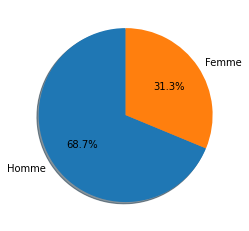

In [ ]:
count=df['gender'].value_counts()
labels = 'Homme','Femme'
sizes = [count[1]/len(df),count[0]/len(df)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

In [ ]:
df_f=data_for_model(df)

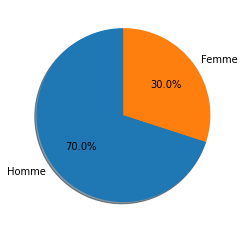

In [ ]:
count=df_f['gender'].value_counts()
labels = 'Homme','Femme'
sizes = [count[1]/len(df_f),count[0]/len(df_f)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

On peut voir que avec cette représentation de la base de doneés, on n'a pas presque rien changer dans les répartition des acteurs entre homme et femme

In [ ]:
df_f.shape

(243916, 3)

##Répartition et préparation des données

dans ce niveau on faire 4 choise:

  - on notera MAX_SEQUENCE_LENGTH la plus long phrase
  - on indexera les mots ( de 1 -> longeur des mots distinct) pour transformer des texts au vecteur 
  - on appliquera le padding qui a pour but de creés des phrases de méme longeur (MAX_SEQUENCE_LENGTH) on complétent les vecteurs par des zeros
  - on divisera les datas en train et test

In [ ]:
see=set()
for i in list(df_f["text__utterance"]):
  see.add(len(i))
MAX_SEQUENCE_LENGTH = max(see)

In [ ]:
x=df_f['text__utterance']
Y=df_f["gender"]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [ ]:
sequences = tokenizer.texts_to_sequences(df_f['text__utterance'])
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(data,Y,test_size=0.3)

In [ ]:
Train_X.shape , Test_X.shape , Train_Y.shape , Test_Y.shape

((170741, 1638), (73175, 1638), (170741,), (73175,))

##Glove

on va creés la matrice embedding a partir du modele " Glove" un model prêt entraîner

In [ ]:
if( 'glove.zip' in os.listdir("/content/gdrive/My Drive")):
  print('glove.zip  file in your drive' )
else:
  urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.840B.300d.zip', 'glove.zip')
  !cp glove.zip "/content/gdrive/My Drive/"

glove.zip  file in your drive


In [ ]:
with zipfile.ZipFile("/content/gdrive/My Drive/glove.zip","r")as myzip:
  l=myzip.namelist()
  f=myzip.open(l[0])

In [ ]:
word_index=tokenizer.word_index
vocab_size=len(word_index) + 1
EMBEDDING_DIM=300
from tqdm import tqdm

In [ ]:
embeddings_index = {}
for line in tqdm(f):
  values = line.split()
  word = str(values[0],'utf-8')
  embeddings_index[word] = np.asarray(values[1:], dtype='float32')

2196017it [03:36, 10137.91it/s]


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

100%|██████████| 41281/41281 [00:00<00:00, 496587.21it/s]

 Completed!


In [ ]:
embedding_matrix.shape

(41282, 300)

##Métrique

On va utilser une fonction indicatrice $\mathbb{1}_{x \leq0.5}$ ( dans le code ind ) puisque notre but et de faire la classification et LSTM et CNN retourn des numéros entre 0 et 1 et pas 0 ou 1.

vue que on a défalqué la base de données, les résultats de f1 sur cette base n'a pas du sens puisque un seul artiste ( qu'on va supposer qu'il est de sexe "s" ) peut avoir plus d'une phrase et pas forcement que notre model va classer toutes ses phrases de sexe "s".

Donc l'idées et de faire un moyenne sur les sorties du model ( c a d si un acteur "a1" a 3 phrases(ph1,ph2 et ph3) et il est de sexe "0" et notre model a classer (ph1 -> 0 , ph2 -> 1 et ph3 -> 0) on va dire que "a1" est de sexe ind(1/3)=0 donc "a1" de sexe 0.

In [ ]:
from tensorflow.python.keras import backend as K
def f1(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return 2 * (K.sum(y_true * y_pred)+ K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

In [ ]:
def ind(n):
  if(n<=0.5):
    return(0)
  else:
    return(1)

In [ ]:
def F1_score(Test_Y,predictions,model_name):
  if(model_name=='svm'):
    y=predictions_SVM
  else:  
    y=[]
    for i in predictions:
      y.append(ind(i))

  d_test={}
  d_pred={}
  list_index=list(Test_Y.index)
  for i in range(len(list_index)):
    idd=df_f.loc[list_index[i]]["id"]
    if(idd in d_test):
      d_test[idd].append(Test_Y[list_index[i]])
      d_pred[idd].append(y[i])
    else:
      d_test[idd]=[]
      d_pred[idd]=[]
      d_test[idd].append(Test_Y[list_index[i]])
      d_pred[idd].append(y[i])
  d_test={i:np.mean(d_test[i]) for i in d_test}
  d_pred={i:ind(np.mean(d_pred[i])) for i in d_pred}
  y_test=list(d_test.values())
  y_pred=list(d_pred.values())

  f1=f1_score(y_test, y_pred)
  print(f1)
  return(f1)

##Modèles LSTM

In [ ]:
model_lstm = tf.keras.models.Sequential()
model_lstm.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length= MAX_SEQUENCE_LENGTH ,trainable = False))
model_lstm.add( LSTM(150, return_sequences=True) )
model_lstm.add(Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(75)))
model_lstm.add(Dense(64,activation = 'relu'))
model_lstm.add(Dense(16,activation = 'relu'))
model_lstm.add(Dense(1,activation = 'sigmoid'))

In [ ]:
model_lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics = [f1])

In [ ]:
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1638, 300)         12384600  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 150)               226200    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                9664      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total params: 12,621,521
Trainable params: 236,921
Non-trainable params: 12,384,600
_________________________________________________________________


In [ ]:
history_lstm=model_lstm.fit(Train_X, Train_Y, epochs = 4, batch_size=128, validation_data=(Test_X, Test_Y),verbose=1)

1334/1334 [==============================] - 432s 324ms/step - loss: 0.5825 - accuracy: 0.7064 - val_loss: 0.5941 - val_accuracy: 0.6996


In [ ]:
predictions_lstm = model_lstm.predict(Test_X)

In [ ]:
f1_lstm=F1_score(Test_Y,predictions_lstm,'LSTM')
model_score['LSTM']=(model_lstm,f1_lstm)

0.8160261651676206


0.8160261651676206

##Modèles CNN 


In [ ]:
model_cnn = tf.keras.models.Sequential()
model_cnn.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable = False))
model_cnn.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model_cnn.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

In [ ]:
model_cnn.compile(optimizer='sgd',loss='binary_crossentropy',metrics = ['accuracy',f1])

In [ ]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1638, 300)         12384600  
_________________________________________________________________
conv1d (Conv1D)              (None, 1634, 128)         192128    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1630, 64)          41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,619,865
Trainable params: 235,265
Non-trainable params: 12,384,600
____________________________________

In [ ]:
history_cnn=model_cnn.fit(Train_X, Train_Y, epochs = 5, batch_size=128, validation_data=(Test_X, Test_Y))

Epoch 1/5
1334/1334 [==============================] - 145s 109ms/step - loss: 0.6119 - accuracy: 0.7005 - f1: 0.6952 - val_loss: 0.6100 - val_accuracy: 0.6990 - val_f1: 0.7033
Epoch 2/5
1334/1334 [==============================] - 144s 108ms/step - loss: 0.6068 - accuracy: 0.7005 - f1: 0.7015 - val_loss: 0.6091 - val_accuracy: 0.6990 - val_f1: 0.6894
Epoch 3/5
1334/1334 [==============================] - 144s 108ms/step - loss: 0.6040 - accuracy: 0.7005 - f1: 0.7029 - val_loss: 0.6058 - val_accuracy: 0.6990 - val_f1: 0.6991
Epoch 4/5
1334/1334 [==============================] - 144s 108ms/step - loss: 0.6014 - accuracy: 0.7007 - f1: 0.7043 - val_loss: 0.6044 - val_accuracy: 0.6988 - val_f1: 0.6997
Epoch 5/5
1334/1334 [==============================] - 144s 108ms/step - loss: 0.5993 - accuracy: 0.7006 - f1: 0.7057 - val_loss: 0.6041 - val_accuracy: 0.6983 - val_f1: 0.6959


In [ ]:
predictions_cnn = model_cnn.predict(Test_X)

In [ ]:
f1_cnn=F1_score(Test_Y,predictions_cnn,'CNN')
model_score['cnn']=(model_cnn,f1_cnn)

##Modèles SVM

In [ ]:
emb = tf.keras.models.Sequential()
emb.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable = False))
emb.add(tf.keras.layers.GlobalAveragePooling1D())

In [ ]:
Train_X_emb=emb.predict(Train_X)
Test_X_emb=emb.predict(Test_X)

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_emb , Train_Y )

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predictions_SVM = SVM.predict(Test_X_emb)

In [ ]:
f1_svm=F1_score(Test_Y, predictions_SVM,'svm')
print(f1_svm)
model_score['svm']=(SVM,f1_svm)


#Prédiction

On va se baser sur les F1_score de chaque model et va prendre le score la plus grand pour predire les sexes des acteur .

##Préparation des données pour la prédiction

In [ ]:
d_id_pred,d_con=data_to_dict(df_ch_pred,df_con)

In [ ]:
df_pred=Merge(d_id_pred,d_con)

In [ ]:
df_pred.head(5)

,id,text__utterance,gender
0,u1,"[alway pleasur bruci, peg gigglepuss fan littl...",?
1,u8,"[miss, say expos group freshmen girl, bratwurs...",?
2,u10,"[microwav, make anyon cri today, synonym throb...",?
3,u12,"[never seen heat like even la mina, water go p...",?
4,u13,"[say asia found sail west, ye emin voyag take ...",?


In [ ]:
df_pred.shape

In [ ]:
df_pred=data_for_model(df_pred)

In [ ]:
X_pred=df_pred['text__utterance']

In [ ]:
sequences = tokenizer.texts_to_sequences(X_pred)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

##Prédiction avec le meilleur model

Par raisonnement similaires dans la partie Métrique on va appliquer la fonction indicatrice sur le moyenne sur les prédictions pour avoire le sexe de chaque acteur.

In [ ]:
def Best_Model(d):
  best_score=0
  best_Model=""
  best_model_name=""
  for i in d:
    if(d[i][1]>best_score):
      best_score=d[i][1]
      best_model_name=i
      best_Model=d[i][0]
  return(best_Modle,best_model_name)

In [ ]:
def prediction(df,model,model_name,X):
  if(model_name=='svm'):
    X=emb.predict(X)
    y=model.predict(X)
  else:
    predictions=model.predict(X)
    y=[]
    for i in predictions:
      y.append(ind(i))
  d={}
  list_index=list(df['text__utterance'].index)
  for i in range(len(list_index)):
    idd=df_f.loc[list_index[i]]["id"]
    if(idd in d):
      d.append(y[i])
    else:
      d_id_pred[idd]=[]
      d[idd].append(y[i])
  d={i:ind(np.mean(d[i])) for i in d}
  
  data=[]
  for i in d:
    data.append([i,d[i]])

  col=["id","gender"]
  df_f=pd.DataFrame(data,columns=col) 
  df['gender'][df["gender"] == 1] = "M" 
  df['gender'][df["gender"] == 0] = "F"
  return(df_f)

In [ ]:
best_model,best_model_name=Best_Model(model_score)
print(best_model_name)

In [ ]:
Predictions = prediction(df_pred,best_model,best_model_name,X)

#etude statistique

On va travail avec la base de donnée de "moviequotes.memorable_nonmemorable_pairs" qu'est labelliser par les phrases qui sont memorable ou pas.

Cette base donnée va etre predite par le model de gendre pour avoir finalement une base qui représente la phrase , la lable mémorable ou pas et le sexe 

et finlament l'etude statistique 

In [ ]:
data_ch=[]
f = open("/content/gdrive/My Drive/data set projet ML/moviequotes.memorable_nonmemorable_pairs.txt", "r",encoding="ISO-8859-1")
for x in f:
  data_ch.append(x)
l2=''.join(data_ch).split("\n\n")
l3=[i.split("\n") for i in l2]    
#l3
col_ch=["MOVIE_TITLE","MEMORABLE_QUOTE","LINE_ID_MEMORABLE MATCHED_QUOTE","LINE_ID_NON_MEMORABLE NON_MEMORABLE_QUOTE"]
df2=pd.DataFrame(l3,columns=col_ch)    
df2.dropna(inplace=True)
#l3[len(l3)-1]

In [ ]:
def f(s):
  l=s.split()
  s1=l[0]
  s2=' '.join(l[1:len(l)])
  return(s1,s2)

a=df2["LINE_ID_MEMORABLE MATCHED_QUOTE"]
b=df2["LINE_ID_NON_MEMORABLE NON_MEMORABLE_QUOTE"]

z=a.apply(f)
z2=b.apply(f)
data=[[i[0],i[1]] for i in z]
data2=[[i[0],i[1]] for i in z2]

dff=pd.DataFrame(data,columns=["LINE_ID_MEMORABLE","MATCHED_QUOTE"])
dff2=pd.DataFrame(data2,columns=["LINE_ID_NON_MEMORABLE","NON_MEMORABLE_QUOTE"])
df_3=pd.concat([df2.reset_index(drop=True),dff.reset_index(drop=True),dff2.reset_index(drop=True)], axis=1)
#df_3.drop(columns=["LINE_ID_MEMORABLE MATCHED_QUOTE","LINE_ID_NON_MEMORABLE NON_MEMORABLE_QUOTE"],inplace=True)

df3=df_3[['MEMORABLE_QUOTE','NON_MEMORABLE_QUOTE',"LINE_ID_NON_MEMORABLE","LINE_ID_MEMORABLE"]]

Memo=list(df3['MEMORABLE_QUOTE'].values)
Non_Memo=list(df3['NON_MEMORABLE_QUOTE'].values)
ID_memo=list(df3['LINE_ID_MEMORABLE'].values)
ID_non_memo=list(df3['LINE_ID_NON_MEMORABLE'].values)

Memo_ind=[1 for i in Memo]
Non_Memo_ind=[0 for i in Non_Memo]

Memo.extend(Non_Memo)
quote=Memo
Memo_ind.extend(Non_Memo_ind)
labels=Memo_ind
ID_memo.extend(ID_non_memo)
ID=ID_memo

df = pd.DataFrame({'quote':quote,'label':labels,'id':ID}, columns=['quote','label','id'])


In [ ]:
df_stat=df.sample(frac=1)

In [ ]:
x_stat_memo=df_stat[df_stat['label']==1]['quote']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_stat_memo)

In [ ]:
sequences = tokenizer.texts_to_sequences(x_stat_memo)
data_stat_memo = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
y_memo=prediction_stat(df_stat,best_model,best_model_name,data_stat_memo)

In [ ]:
df_stat_memo=df_stat[df_stat['label']==1]
df_stat_memo["gender"]=y_memo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


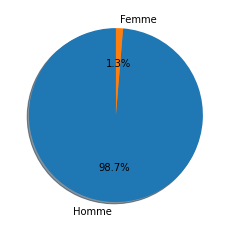

In [ ]:
count=df_stat_memo['gender'].value_counts()
labels = 'Homme','Femme'
sizes = [count[1]/len(df_stat_memo),count[0]/len(df_stat_memo)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

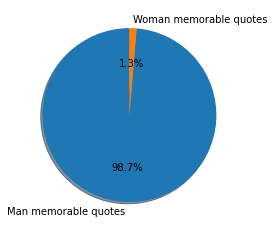

In [ ]:
count=df_stat_memo[df_stat_memo['label']==1]['gender'].value_counts()
labels = 'Man memorable quotes','Woman memorable quotes'
sizes = [count[1]/len(df_stat_memo),count[0]/len(df_stat_memo)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()